In [1]:
import fenics as fn
import numpy as np
#
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
#
from matplotlib import pyplot as plt
#
from copy import copy
from time import time

$$\frac{\partial}{\partial t}\begin{pmatrix} y_1 \\ y_2 \end{pmatrix} - 
\nu\begin{pmatrix}\Delta & 0 \\ 0 & \Delta\end{pmatrix} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix} + \begin{pmatrix}0 & \gamma_1 \\ \gamma_2 & 0\end{pmatrix} \begin{pmatrix} y_1 \\ y_2 \end{pmatrix} = \begin{pmatrix} f_1 \\ f_2 \end{pmatrix}$$

**Parameters**

In [2]:
Ne = 100
nu = 0.1 #0.1
dt = 0.01
T  = 0.5
t_vector = np.linspace(0,T,int(T/dt)+1)
Nt = t_vector.shape[0]
#
gamma1, gamma2 = 1., 2.
#
K        = 1.2e+3 # 500 for sigma2
ALPHA    = .01
STOP_CRI = 1.e-5
OBS_DOM  = (0.5,0.9)

In [3]:
label_str = 'ex01_f1_sigma1_obs_0.5_0.9'

In [4]:
def sigma(t):
    return 1. + 0.*t
############################################################################
#def sigma(t):
#    t0 = 3*T/4
#    aux = (1 + 2*t/t0 - (t/t0)**2)*(t < t0) + (2. + t*0)*(t >= t0)
#    return aux
############################################################################
#def sigma(t):
#    eps = T/10
#    aux = (1 + (np.cos(4*np.pi*t/(T-eps))/2))*(t < T - eps) + 3/2*(t >= T - eps)
#    return aux
############################################################################

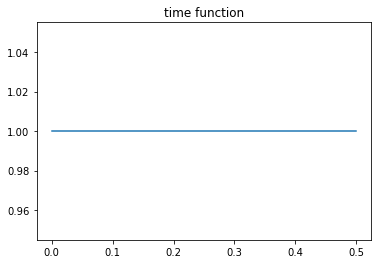

In [5]:
plt.plot(t_vector,sigma(t_vector))
plt.title('time function')
plt.show()

In [6]:
print('elements:',Ne)
print('time steps:',t_vector.shape[0])

elements: 100
time steps: 51


**Mesh and FE spaces**

In [7]:
mesh = fn.IntervalMesh(Ne,0,1)
U1   = fn.FiniteElement("CG", mesh.ufl_cell(), 1)
U2   = fn.FiniteElement("CG", mesh.ufl_cell(), 1)
Un   = fn.FunctionSpace(mesh, U1*U2)

**Trial and test functions**

In [8]:
(u1, u2) = fn.TrialFunctions(Un)
(v1, v2) = fn.TestFunctions(Un)

**Observation subdomain**

In [9]:
#
obs_1 = OBS_DOM[0]
obs_2 = OBS_DOM[1]
class Omega0(fn.SubDomain):
    def inside(self, x, on_boundary):
        return (fn.between(x[0], (obs_1, obs_2)))
#
omega0 = Omega0()
#
domains = fn.MeshFunction("size_t", mesh, mesh.topology().dim())
domains.set_all(0)
omega0.mark(domains, 1)  
#
dx_obs = fn.Measure("dx", domain=mesh, subdomain_data=domains)
# subdomain as indicator function
obs_dom_str = 'o1 <= x[0] && x[0] <= o2 ? 1. : 0.'
obs_dom_exp = fn.Expression((obs_dom_str,obs_dom_str), o1=obs_1, o2=obs_2, degree=0)

**Initial conditions**

In [10]:
ini_con = fn.Expression(('0.*x[0]','0.*x[0]'), degree=2)
u_ini = fn.Function(Un)
u_ini.interpolate(ini_con)
#u0_dof = u_ini.vector()[:]

**Boundary conditions**

In [11]:
g = fn.Constant((0.,0.))
bc = fn.DirichletBC(Un, g, 'on_boundary')

In [12]:
b_forw = (u1*v1)*(fn.dx) + dt*nu*fn.dot(fn.grad(u1),fn.grad(v1))*(fn.dx) + dt*gamma1*(u2*v1)*(fn.dx) + (u2*v2)*(fn.dx) + dt*nu*fn.dot(fn.grad(u2),fn.grad(v2))*(fn.dx) + dt*gamma2*(u1*v2)*(fn.dx)
b_back = (u1*v1)*(fn.dx) + dt*nu*fn.dot(fn.grad(u1),fn.grad(v1))*(fn.dx) + dt*gamma2*(u2*v1)*(fn.dx) + (u2*v2)*(fn.dx) + dt*nu*fn.dot(fn.grad(u2),fn.grad(v2))*(fn.dx) + dt*gamma1*(u1*v2)*(fn.dx)
# Matrices assemble (Fenics structure)
B_forw = fn.assemble(b_forw)
B_back = fn.assemble(b_back)
# Include BC's
bc.apply(B_forw)
bc.apply(B_back)
# Matrices to numpy array
B_forw_np = B_forw.array()
B_back_np = B_back.array()
# Matrices to sparse structure
B_forw_sp = sp.csr_matrix(B_forw_np)
B_back_sp = sp.csr_matrix(B_back_np)

In [13]:
def coupled_forward(u0, rhs,t_vector):
    '''
    This function has a input the initial condition of the system
    u0 (as a Fenics function) and the rhs (f1,f2) as a list with the DoF
    at each time
    Return: the solution's DoF of the system for all times (and its derivative)
    '''
    # Initial condition
    u_ini = fn.Function(Un)
    u_ini.vector()[:] = u0.vector()[:]
    u01, u02 = u_ini.split()
    #
    sol_list = []
    sol_t_list = []
    #sol_list.append(u_ini.vector()[:])
    f = fn.Function(Un)
    f.vector()[:] = rhs
    f1, f2 = f.split()
    #loop
    #for idx in range(t_vector[1:].shape[0]):
    for idx in range(t_vector.shape[0]):    
        #print(idx)
        #
        L  = (dt*sigma(t_vector[idx])*f1*v1 + u01*v1)*(fn.dx) + (dt*sigma(t_vector[idx])*f2*v2 + u02*v2)*(fn.dx)
        rhs = fn.assemble(L)
        bc.apply(rhs)
        #
        u_sol = fn.Function(Un)
        # Sparse solver
        #fn.solve(b_forw==L,u_sol,bc)
        aux = spsolve(B_forw_sp,rhs[:])
        #
        u_sol.vector()[:] = aux
        u01, u02 = u_sol.split()
        #
        sol_list.append(u_sol.vector()[:])
    ######################################################    
    # here we added the time derivative
    sol_t_list.append((sol_list[0] - u_ini.vector()[:])/dt)
    for idx in range(1,t_vector.shape[0]):
        sol_t_list.append((sol_list[idx] - sol_list[idx-1])/dt)
    ######################################################        
    return sol_list, sol_t_list
def coupled_backward(y,y_t,observations,observations_t,t_vector,k=1.):
    '''
    This function has a input the final contition (at time T) 
    of the system as the DoF of a Fenics function 
    Return: the solution of the system (as a list with the DoF at each time)
    '''
    # Initial condition
    u_T = fn.Function(Un)
    u_T.vector()[:] = 0.
    u01, u02 = u_T.split()
    #
    y_out = []
    #y_out.append(u_T.vector()[:])
    #loop
    #for idx in reversed(range(t_vector[:-1].shape[0])):
    for idx in reversed(range(t_vector.shape[0])):    
        y_fn = fn.Function(Un)
        y_fn.vector()[:] = y[idx]
        y1_fn, y2_fn = y_fn.split()
        #
        y_t_fn = fn.Function(Un)
        y_t_fn.vector()[:] = y_t[idx]
        y1_t_fn, y2_t_fn = y_t_fn.split()
        #
        y_obs = fn.Function(Un)
        y_obs.vector()[:] = observations[idx]
        y1_obs, y2_obs = y_obs.split()
        #
        y_t_obs = fn.Function(Un)
        y_t_obs.vector()[:] = observations_t[idx]
        y1_t_obs, y2_t_obs = y_t_obs.split()
        #
        L  = u01*v1*(fn.dx) + u02*v2*(fn.dx) - dt*k*(y1_fn - y1_obs)*v1*(dx_obs(1)) - dt*k*(y2_fn - y2_obs)*v2*(dx_obs(1))\
                             - dt*k*(y1_t_fn - y1_t_obs)*v1*(dx_obs(1))   - dt*k*(y2_t_fn - y2_t_obs)*v2*(dx_obs(1))
                                      # - dt*k*(y1_t_fn - y1_t_obs)*v1*(dx_obs(1))   - dt*k*(y2_t_fn - y2_t_obs)*v2*(dx_obs(1))
                           #- dt*k*(y1_fn - y1_obs).dx(0)*v1*(dx_obs(1)) - dt*k*(y2_fn - y2_obs).dx(0)*v2*(dx_obs(1))#\
                     
        rhs = fn.assemble(L)
        bc.apply(rhs)
        #
        u_sol = fn.Function(Un)
        # Sparse solver
        #fn.solve(b_back==L,u_sol,bc)
        aux = spsolve(B_back_sp,rhs[:])
        #
        u_sol.vector()[:] = aux
        u01, u02 = u_sol.split()
        #
        y_out.append(u_sol.vector()[:])
    # reverse the list to get first t=0 and last t=T
    y_out = list(reversed(y_out))
    return y_out

## FORWARD PROBLEM

In [14]:
#################################################################################
f_exp = fn.Expression(('sin(2*pi*x[0])','-sin(2*pi*x[0])'), degree = 2)
#################################################################################
#f1_str = '0.1 <= x[0] && x[0] <= 0.6 ? (0.35 <= x[0] && x[0] <= 0.6 ? 8*(0.6 - x[0]) : 8*(x[0] - 0.1)) : 0.'
#f2_str = '0.4 <= x[0] && x[0] <= 0.9 ? (0.65 <= x[0] && x[0] <= 0.9 ? 8*(0.9 - x[0]) : 8*(x[0] - 0.4)) : 0.'
#f_exp = fn.Expression((f1_str,f2_str),t=0., degree=1)
#################################################################################
#f1_str = '0.2 <= x[0] && x[0] <= 0.5 ? 1. : 0.'
#f2_str = '0.5 <= x[0] && x[0] <= 0.8 ? 1. : 0.'
#f_exp = fn.Expression((f1_str,f2_str),t=0., degree=0)
#################################################################################
#rhs_list = []
f_exact = fn.Function(Un)
f_exact.interpolate(f_exp)
f_exact_dof = copy(f_exact.vector()[:])

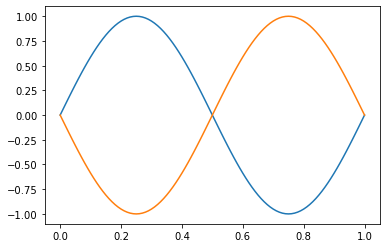

In [15]:
fn.plot(f_exact.sub(0))
fn.plot(f_exact.sub(1))

**Observations over the observation subdomain**

In [16]:
sol_forward, sol_t_forward = coupled_forward(u_ini,f_exact_dof,t_vector)
#
obs_fn = fn.Function(Un)
obs_fn.interpolate(obs_dom_exp)
#
observations = []
observations_t = []
for idx in range(len(sol_forward)):
    observations.append(sol_forward[idx])
    observations_t.append(sol_t_forward[idx])

## BACKWARD PROBLEM

In [17]:
fn.set_log_level(30)

**Inverse problem functional** defined by
$$\inf_{f\in L^2(\mathcal{\Omega})}\left(\frac{1}{2}\int_{\Omega} f^2 \,dx + \frac{k}{2}\|y - y_{obs}\|_{L^2(\mathcal{O}\times (0,T))}^2 + \frac{k}{2}\|\partial_t y - \partial_t y_{obs}\|_{L^2(\mathcal{O}\times (0,T))}^2\right)\qquad (1.116)$$

## Gradient Descent

**Initial** $f^0$

In [18]:
f0_fn = fn.Function(Un)
f0_fn.vector()[:] = 1.0
f_old = copy(f0_fn.vector()[:])

$\displaystyle C_\sigma = \int_{0}^{T} \sigma(t)\,dx \approx \Delta t \sum_{i=1}^{N_t} dt\sigma\left(\frac{t(i) + t(i+1)}{2}\right)$

In [19]:
mid_point = (t_vector[:-1] + t_vector[1:])/2
C_sigma = dt*np.sum(sigma(mid_point))

- $f^{0}$ given. (here $F(x,t) = f(x)\sigma(t)$)
- set **tol** to a small value.
- set $\alpha$

while stop_cri > **tol** do:
- $Y^{n} = \text{forward}(f^{n},\sigma,y_0)$
- $\varphi^{n} = \text{backward}(Y^{n},Y_{\text{obs}},\varphi_0=0)$
- $\frac{\partial J}{\partial f}(f^n) = C_\sigma f^{n} - \int_{0}^{T}\sigma(t)\varphi^{n}(\cdot,t)$
- $f^{n+1} = f^{n} - \alpha \frac{\partial J}{\partial f}(f^n)$

- $\text{stop_cri} = \displaystyle\left\|\frac{\partial J}{\partial f}(f^n)\right\| = \sqrt{\int_{\Omega} \left(\frac{\partial J}{\partial f}(f^n)\right)^2}$

In [20]:
def GD_step(f_old,alpha=0.1):
    y_old, y_t_old = coupled_forward(u_ini,f_old,t_vector)
    phi_old = coupled_backward(y_old,y_t_old,observations,observations_t,t_vector,k=K)
    #
    #f_new = []
    sigma_phi_t_int = np.zeros_like(f_old)
    # time-integrals
    for idx in range(t_vector.shape[0]-1):
        sigma_phi_t_int += dt*(sigma(t_vector[idx])*phi_old[idx] + sigma(t_vector[idx+1])*phi_old[idx+1])/2   
    # gradient of J    
    grad_J = C_sigma*f_old - sigma_phi_t_int
    # GD step
    f_new = copy(f_old - alpha*grad_J)  
    # stop criteria
    grad_J_fn = fn.Function(Un)
    grad_J_fn.vector()[:] = grad_J
    difference = np.sqrt(fn.assemble(grad_J_fn**2*(fn.dx)))
    #difference = np.linalg.norm(f_new[idx] - f_old[idx])
    return f_new, difference

In [21]:
t0 = time()
for i in range(4096): # 4096 8192
    f_old, stop_cri = GD_step(f_old,alpha=ALPHA)
    print('criteria =',stop_cri)
    if (stop_cri < STOP_CRI):
        break
print('time: ',(time() - t0)/60,'[min]')        

criteria = 90.5789762680821
criteria = 55.35561471904626
criteria = 31.06549543069794
criteria = 18.923533125693165
criteria = 11.725424894286624
criteria = 7.3582844135960475
criteria = 5.397222001025392
criteria = 3.765423019083903
criteria = 3.1900616214730033
criteria = 2.511866386001517
criteria = 2.2459062209883753
criteria = 1.9157781257850435
criteria = 1.7488934592901084
criteria = 1.5702146312009952
criteria = 1.4611089059994562
criteria = 1.3583799633544253
criteria = 1.2872167852926188
criteria = 1.2243494033276188
criteria = 1.1763758553766037
criteria = 1.1344155411427623
criteria = 1.0997003207634892
criteria = 1.068700642150329
criteria = 1.041369110573382
criteria = 1.01624601758928
criteria = 0.9931028403066895
criteria = 0.9713130915436108
criteria = 0.9506996946359261
criteria = 0.9309840165838683
criteria = 0.9120571626157882
criteria = 0.8937902079674613
criteria = 0.8761205292506316
criteria = 0.8589851441858857
criteria = 0.8423477827493164
criteria = 0.82617498

criteria = 0.10022259997597256
criteria = 0.09963514095582736
criteria = 0.09905149878010969
criteria = 0.09847164420821833
criteria = 0.09789554830268797
criteria = 0.09732318242394684
criteria = 0.09675451822521862
criteria = 0.09618952764756322
criteria = 0.09562818291506266
criteria = 0.0950704565301297
criteria = 0.09451632126895046
criteria = 0.09396575017704999
criteria = 0.09341871656497273
criteria = 0.09287519400408341
criteria = 0.09233515632247244
criteria = 0.09179857760097714
criteria = 0.09126543216929679
criteria = 0.0907356946022141
criteria = 0.09020933971591268
criteria = 0.08968634256438159
criteria = 0.0891666784359241
criteria = 0.08865032284973307
criteria = 0.08813725155257005
criteria = 0.08762744051551394
criteria = 0.08712086593079409
criteria = 0.08661750420869363
criteria = 0.08611733197453288
criteria = 0.08562032606571995
criteria = 0.08512646352886909
criteria = 0.08463572161699219
criteria = 0.08414807778674496
criteria = 0.08366350969574124
criteria = 

criteria = 0.02331786414815617
criteria = 0.023194265460872224
criteria = 0.02307134840667769
criteria = 0.022949108979772842
criteria = 0.0228275432001785
criteria = 0.02270664711354398
criteria = 0.022586416790964667
criteria = 0.022466848328798143
criteria = 0.0223479378484796
criteria = 0.02222968149634229
criteria = 0.022112075443437528
criteria = 0.021995115885357696
criteria = 0.021878799042057712
criteria = 0.02176312115768139
criteria = 0.021648078500387583
criteria = 0.021533667362177114
criteria = 0.021419884058722603
criteria = 0.021306724929197784
criteria = 0.0211941863361115
criteria = 0.02108226466513849
criteria = 0.020970956324955544
criteria = 0.02086025774707726
criteria = 0.020750165385691518
criteria = 0.020640675717501215
criteria = 0.02053178524156167
criteria = 0.020423490479120884
criteria = 0.020315787973466424
criteria = 0.020208674289763074
criteria = 0.02010214601490326
criteria = 0.01999619975734867
criteria = 0.019890832146982385
criteria = 0.01978603983

criteria = 0.006082084908260114
criteria = 0.006050935654040058
criteria = 0.006019948218431676
criteria = 0.0059891217392849866
criteria = 0.0059584553592419
criteria = 0.00592794822570816
criteria = 0.005897599490823219
criteria = 0.005867408311434144
criteria = 0.005837373849066739
criteria = 0.005807495269897884
criteria = 0.005777771744728539
criteria = 0.005748202448956163
criteria = 0.00571878656254715
criteria = 0.005689523270010635
criteria = 0.005660411760370521
criteria = 0.005631451227140862
criteria = 0.005602640868296646
criteria = 0.005573979886250167
criteria = 0.005545467487823417
criteria = 0.005517102884222033
criteria = 0.005488885291010435
criteria = 0.005460813928085351
criteria = 0.005432888019651409
criteria = 0.005405106794193975
criteria = 0.005377469484456111
criteria = 0.0053499753274125796
criteria = 0.005322623564244593
criteria = 0.005295413440316636
criteria = 0.005268344205149926
criteria = 0.005241415112400267
criteria = 0.005214625419832124
criteria =

criteria = 0.0016650095359452065
criteria = 0.0016565777753490068
criteria = 0.0016481889095664416
criteria = 0.001639842718460873
criteria = 0.0016315389830434941
criteria = 0.0016232774854676429
criteria = 0.0016150580090225452
criteria = 0.0016068803381273204
criteria = 0.0015987442583244912
criteria = 0.001590649556274814
criteria = 0.0015825960197501704
criteria = 0.001574583437628854
criteria = 0.001566611599888387
criteria = 0.0015586802976007665
criteria = 0.001550789322925585
criteria = 0.001542938469105386
criteria = 0.0015351275304583344
criteria = 0.0015273563023740417
criteria = 0.00151962458130682
criteria = 0.001511932164770172
criteria = 0.0015042788513315113
criteria = 0.001496664440606086
criteria = 0.0014890887332515725
criteria = 0.0014815515309624806
criteria = 0.0014740526364647234
criteria = 0.001466591853509714
criteria = 0.0014591689868695677
criteria = 0.0014517838423310692
criteria = 0.0014444362266905597
criteria = 0.0014371259477481049
criteria = 0.00142985

criteria = 0.00046914368621922114
criteria = 0.00046677588071917695
criteria = 0.0004644200414908198
criteria = 0.000462076107899513
criteria = 0.0004597440196193953
criteria = 0.00045742371663206726
criteria = 0.00045511513922469825
criteria = 0.0004528182279885594
criteria = 0.00045053292381758316
criteria = 0.0004482591679065112
criteria = 0.00044599690174979917
criteria = 0.00044374606713962103
criteria = 0.0004415066061645359
criteria = 0.00043927846120806873
criteria = 0.00043706157494694805
criteria = 0.00043485589034985997
criteria = 0.00043266135067578863
criteria = 0.00043047789947254486
criteria = 0.00042830548057512275
criteria = 0.0004261440381047919
criteria = 0.0004239935164668475
criteria = 0.000421853860349655
criteria = 0.0004197250147232174
criteria = 0.000417606924837368
criteria = 0.0004154995362206839
criteria = 0.00041340279467884714
criteria = 0.00041131664629337434
criteria = 0.0004092410374201095
criteria = 0.0004071759146876786
criteria = 0.000405121224996489

criteria = 0.00013590297710283685
criteria = 0.00013521770750580983
criteria = 0.00013453589462476
criteria = 0.00013385752101016267
criteria = 0.0001331825693007845
criteria = 0.00013251102222307912
criteria = 0.00013184286259087136
criteria = 0.00013117807330475243
criteria = 0.00013051663735209702
criteria = 0.0001298585378057661
criteria = 0.00012920375782459953
criteria = 0.00012855228065245254
criteria = 0.00012790408961780181
criteria = 0.00012725916813351192
criteria = 0.00012661749969625278
criteria = 0.00012597906788601522
criteria = 0.00012534385636593835
criteria = 0.000124711848881588
criteria = 0.00012408302926080036
criteria = 0.00012345738141319724
criteria = 0.00012283488932950926
criteria = 0.00012221553708158966
criteria = 0.00012159930882178138
criteria = 0.00012098618878234125
criteria = 0.00012037616127533792
criteria = 0.00011976921069227997
criteria = 0.00011916532150331792
criteria = 0.00011856447825714822
criteria = 0.00011796666558061074
criteria = 0.00011737

criteria = 3.899995727334388e-05
criteria = 3.8803370394071596e-05
criteria = 3.860777463940258e-05
criteria = 3.8413165011171095e-05
criteria = 3.821953653659327e-05
criteria = 3.802688426787875e-05
criteria = 3.783520328217061e-05
criteria = 3.76444886814898e-05
criteria = 3.745473559252428e-05
criteria = 3.726593916673393e-05
criteria = 3.70780945796752e-05
criteria = 3.6891197031545684e-05
criteria = 3.6705241746637264e-05
criteria = 3.6520223973478404e-05
criteria = 3.633613898426015e-05
criteria = 3.61529820752697e-05
criteria = 3.597074856656561e-05
criteria = 3.5789433801602705e-05
criteria = 3.5609033147463457e-05
criteria = 3.542954199451302e-05
criteria = 3.5250955756566144e-05
criteria = 3.507326987029978e-05
criteria = 3.489647979564346e-05
criteria = 3.4720581015268415e-05
criteria = 3.454556903468634e-05
criteria = 3.437143938212306e-05
criteria = 3.41981876083085e-05
criteria = 3.4025809286401375e-05
criteria = 3.3854300011939646e-05
criteria = 3.368365540274938e-05
cri

criteria = 1.1366397257670999e-05
criteria = 1.130911582756201e-05
criteria = 1.1252123124754626e-05
criteria = 1.1195417693746997e-05
criteria = 1.1138998086253484e-05
criteria = 1.108286286125364e-05
criteria = 1.102701058512618e-05
criteria = 1.0971439831532003e-05
criteria = 1.0916149181110717e-05
criteria = 1.0861137221658908e-05
criteria = 1.080640254842056e-05
criteria = 1.0751943763449263e-05
criteria = 1.0697759475916048e-05
criteria = 1.0643848301911508e-05
criteria = 1.0590208864548773e-05
criteria = 1.0536839794197706e-05
criteria = 1.0483739727471839e-05
criteria = 1.0430907308489351e-05
criteria = 1.0378341187923779e-05
criteria = 1.0326040023223197e-05
criteria = 1.0274002478771171e-05
criteria = 1.0222227225458804e-05
criteria = 1.0170712941067821e-05
criteria = 1.0119458309992617e-05
criteria = 1.0068462023258355e-05
criteria = 1.0017722778480596e-05
criteria = 9.967239279696674e-06
time:  22.170762578646343 [min]


In [22]:
np.save('data/source_recons_'+label_str,f_old)
np.savez('data/parameters_'+label_str,
         f_old=f_old,
         f_exact_dof = f_exact_dof,
         Ne=Ne,
         t_vector=t_vector,
         sigma_vector = sigma(t_vector),
         nu=nu,
         gamma1=gamma1,
         gamma2=gamma2,
         K        = K,
         ALPHA    = ALPHA,
         STOP_CRI = STOP_CRI,
         OBS_DOM = OBS_DOM,
        )

**$|y - y_{obs}| + |\partial_t y - \partial_t y_{obs}|$**

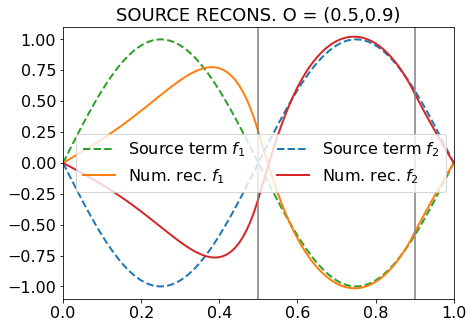

In [23]:
f1_obs, f2_obs = f_exact.split()
#
f_rec = fn.Function(Un)
f_rec.vector()[:] = f_old
f1_rec, f2_rec = f_rec.split()
#
plt.figure(figsize=(7,5))
fn.plot(f1_obs,label='Source term $f_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f1_rec,label='Num. rec. $f_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f2_obs,label='Source term $f_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(f2_rec,label='Num. rec. $f_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.,1.)
#plt.ylim(None,2.7)
plt.axvline(OBS_DOM[0],color='tab:gray')
plt.axvline(OBS_DOM[1],color='tab:gray')
plt.title('SOURCE RECONS. O = (%1.1f,%1.1f)'%(OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)
#
plt.show()
#title_str = 'IP_num_rec_2_sub_dom_(%1.1f,%1.1f)'%(OBS_DOM[0],OBS_DOM[1])
#plt.savefig('Images/'+title_str+'.png', dpi=600, facecolor=None, edgecolor=None,
#            orientation='portrait', format='png',transparent=True, 
#            bbox_inches='tight', pad_inches=0.1, metadata=None)

**Uniqueness sanity check**

In [24]:
sol_check, sol_t_check = coupled_forward(u_ini,f_old,t_vector)

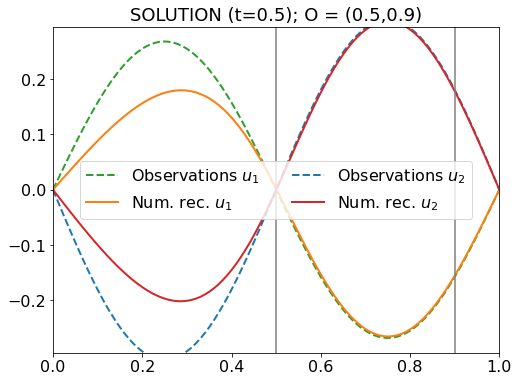

In [25]:
idx = -1
u_obs = fn.Function(Un)
u_obs.vector()[:] = observations[idx]
#
u_rec = fn.Function(Un)
u_rec.vector()[:] = sol_check[idx]
#
plt.figure(figsize=(8,6))
fn.plot(u_obs.sub(0),label='Observations $u_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(0),label='Num. rec. $u_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_obs.sub(1),label='Observations $u_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(1),label='Num. rec. $u_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.,1.)
#plt.ylim(None,2.7)
plt.axvline(OBS_DOM[0],color='tab:gray')
plt.axvline(OBS_DOM[1],color='tab:gray')
#
plt.title('SOLUTION (t=%1.1f); O = (%1.1f,%1.1f)'%(t_vector[idx],OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)
plt.show()

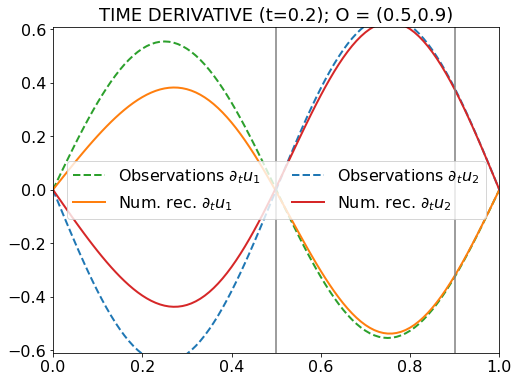

In [26]:
idx = 20
u_obs = fn.Function(Un)
u_obs.vector()[:] = observations_t[idx]
#
u_rec = fn.Function(Un)
u_rec.vector()[:] = sol_t_check[idx]
#
plt.figure(figsize=(8,6))
fn.plot(u_obs.sub(0),label='Observations $\partial_t u_1$',
        color='tab:green',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(0),label='Num. rec. $\partial_t u_1$',
        color='tab:orange',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_obs.sub(1),label='Observations $\partial_t u_2$',
        color='tab:blue',
         linestyle='--',
         marker=None,
         linewidth=2.0,
       )
fn.plot(u_rec.sub(1),label='Num. rec. $\partial_t u_2$',
        color='tab:red',
         linestyle='-',
         marker=None,
         linewidth=2.0,
       )
#
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0.,1.)
#plt.ylim(None,2.7)
plt.axvline(OBS_DOM[0],color='tab:gray')
plt.axvline(OBS_DOM[1],color='tab:gray')
#
plt.title('TIME DERIVATIVE (t=%1.1f); O = (%1.1f,%1.1f)'%(t_vector[idx],OBS_DOM[0],OBS_DOM[1]),fontsize=18)
plt.legend(ncol=2,fontsize=16)